Импортируем библиотеки

In [704]:
import numpy as np
import networkx as nx
import random

np.random.seed(123)
import matplotlib.pyplot as plt
from fractions import Fraction
import seaborn as sns

Класс "Скрытые марковские цепи"

In [754]:
class HiddenMarkovModel:
    
    def __init__(self, observations_amount):
        self.M = 2
        self.pi = self.read_matrix('pi.txt')[0]
#         self.pi = np.ones(self.M)/self.M
        self.A = self.read_matrix('matrix_A.txt')
        self.B = self.read_matrix('matrix_B.txt')
        self.L = observations_amount
    
    def read_matrix(self, file_name):
        matrix = []
        with open(file_name, 'r') as file:
            for line in file:
                matrix.append([float(Fraction(x)) for x in line.split()])
        return np.array(matrix)
    
    def output(self, to_out):
        with open('output_path.txt', 'w') as file:
            for i in to_out:
                file.write('%i\t'%i)
            file.close()
        
    def viterbi_algorithm(self, X):
        delta = np.zeros((self.L, self.M))
        psi = np.zeros((self.L, self.M))
        delta[0, 0] = 1

        delta[0] = np.log(self.pi) + np.log(self.B[:, X[0] - 1])
        for i in range(1, self.L):
            for l in range(self.M):
                delta[i, l] = np.max(delta[i-1] + np.log(self.A[:, l])) + np.log(self.B[l, X[i]-1])
                psi[i, l] = np.argmax(delta[i-1] + np.log(self.A[:, l]))
        
        # Backtrack 
        states = np.zeros(self.L, dtype=np.int32)
        states[self.L - 1] = np.argmax(delta[self.L - 1])
        for t in range(self.L - 2, -1, -1):
            states[t] = psi[t + 1, states[t + 1]]
        return states
    
    def forward_algorithm(self, X):
        alpha = np.zeros((self.L, self.M))

        # Initial value step
        for i in range(self.M):
            alpha[0,i] = self.pi[i]*self.B[i, X[0] - 1]
        alpha[0,0] = 1

        # Induction Step
        for i in range(1, self.L):
#             alpha[i] = alpha[i - 1].dot(self.A) * self.B[:, X[i] - 1]
            for l in range(self.M):
                for k in range(self.M):
                    alpha[i, l] += alpha[i - 1, k]*self.A[k,l]*self.B[l, X[i] - 1]
    
#         sequence_probability = alpha[-1].sum()
        sequence_probability = 0
        for k in range(self.M):
            sequence_probability += alpha[len(alpha)-1, k] * self.A[k, 0]
        print('Forward algorithm. Sequence Probability: ', sequence_probability)
        return alpha, sequence_probability
    
    def backward_algorithm(self, X):
        beta = np.zeros((self.L, self.M))
        for i in range(self.M):
            beta[self.L - 1,i] = self.A[i, 0]
            
        # Induction Step
        for i in range(self.L - 2, 0, -1):
#             beta[i] = self.A.dot(self.B[:, X[i + 1] - 1] * beta[i + 1])
            for k in range(self.M):
                for l in range(self.M):
                    beta[i, k] += self.A[k,l] * self.B[l, X[i+1] - 1] * beta[i+1, l]
        
        sequence_probability = 0
        for l in range(self.M):
            sequence_probability += self.A[0, l] * self.B[l, X[1] - 1] * beta[1, l]
        print('Backward algorithm. Sequence Probability: ', sequence_probability)
        return beta, seq_prob
    
    def posterior_decoding(self, alpha, beta, sequence_probability):
        post = []
        for i in range(self.L):
            post.append(alpha[i, 0] * beta[i, 0] / sequence_probability)
        return post
            
    def next_state(self, weights):
        choice = random.random() * sum(weights)
        for i, w in enumerate(weights):
            choice -= w
            if choice < 0:
                return i
        
    def create_hidden_sequence(self):
        out = [None] * self.L
        out[0] = self.next_state(self.pi)
        for i in range(1, self.L):
            out[i] = self.next_state(self.A[out[i - 1]])
        return out

    def create_observation_sequence(self, hidden_sequence):
        length = len(hidden_sequence)
        out = [None]*length
        for i in range(length):
            out[i] = self.next_state(self.B[hidden_sequence[i]])
        return out

Сгенерируем последовательность из 500 наблюдений.

In [717]:
work = HiddenMarkovModel(500)

hidden=np.array(work.create_hidden_sequence())
observed=np.array(work.create_observation_sequence(hidden))

states = work.viterbi_algorithm(hidden)
alpha, forward_seq_prob = work.forward_algorithm(hidden)
beta, backward_seq_prob = work.backward_algorithm(hidden)
post = work.posterior_decoding(alpha, beta, seq_prob)

Forward algorithm. Sequence Probability:  1.1517142357511954e-277
Backward algorithm. Sequence Probability:  1.1364450358983815e-277


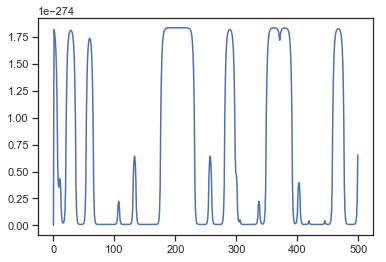

In [718]:
fig, ax = plt.subplots()
sns.lineplot(np.arange(0, 500), post, ax=ax)
# sns.lineplot(np.arange(0, 500), states, ax=ax)

Рассмотрим последовательность, предложенную в книге

In [730]:
lines = ['315116246446644245311321631164',
        'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',
        '152133625144543631656626566666',
        'FFFFFFFFFFFFFFFLLLLLLLLLLLLLLL',
        '651166453132651245636664631636',
        'LLLLLLFFFFFFFFFFFFLLLLLLLLLLLL',
        '663162326455236266666625151631',
        'LLLLFFFLLLLLLLLLLLLLLFFFFFFFFF',
        '222555441666566563564324364131',
        'FFFFFFFFLLLLLLLLLLLLLFFFFFFFFF',
        '513465146353411126414626253356',
        'FFFFFFFFFFFFFFFFFFFFFFFFFFFFLL',
        '366163666466232534413661661163',
        'LLLLLLLLFFFFFFFFFFFFFFFFFFFFFF',
        '252562462255265252266435353336',
        'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',
        '233121625364414432335163243633',
        'FFFFFFFFFFFFFFFFFFFFFFFFFFFLLL',
        '665562466662632666612355245242',
        'LLLLLLLLLLLLLLLLLLLFFFFFFFFFFF']
observation_lines = [line for i, line in enumerate(lines) if i%2 == 0]
observations = [int(x) for x in ''.join(observation_lines)]
estimate_lines = [line for i, line in enumerate(lines) if i%2 == 1]
estimates = [0 if x == 'F' else 1 for x in ''.join(estimate_lines)]

print('Длина последовательности %i'%len(observations))

Длина последовательности 300


Воспользуемся заявленными алгоритмами.

In [755]:
work = HiddenMarkovModel(len(observations))
states = work.viterbi_algorithm(observations)
alpha, forward_seq_prob = work.forward_algorithm(observations)
beta, backward_seq_prob = work.backward_algorithm(observations)
post = work.posterior_decoding(alpha, beta, forward_seq_prob)

Forward algorithm. Sequence Probability:  2.7770538408188514e-224
Backward algorithm. Sequence Probability:  2.741412683586169e-224


Рассмотрим полученный результат:
- наблюдения
- ожидаемые состояния цепи
- полученные состояния цепи

In [756]:
print(observations[:70])
print(estimates[:70])
print(list(states[:70]))

[3, 1, 5, 1, 1, 6, 2, 4, 6, 4, 4, 6, 6, 4, 4, 2, 4, 5, 3, 1, 1, 3, 2, 1, 6, 3, 1, 1, 6, 4, 1, 5, 2, 1, 3, 3, 6, 2, 5, 1, 4, 4, 5, 4, 3, 6, 3, 1, 6, 5, 6, 6, 2, 6, 5, 6, 6, 6, 6, 6, 6, 5, 1, 1, 6, 6, 4, 5, 3, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


Запишем получившуюся последовательность состояний states в файл.

In [757]:
work.output(states)

Сверим ожидаемые состояния и полученные состояния:

In [722]:
correct =  0
for i in range(len(estimates)):
    if estimates[i] == states[i]:
        correct += 1

print('The length of observations: ', len(observations))
print('Correct: ', correct)

The length of observations:  300
Correct:  272


Вывод: результат довольно близок к истине.

Построим график апостериорной вероятности. Оранжевым выделены области, где был использован подкрученный кубик, согласно полученной последовательности состояний.

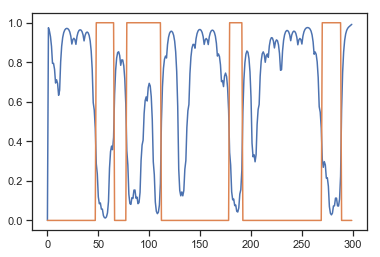

In [723]:
fig, ax = plt.subplots()
sns.lineplot(np.arange(0, len(observations)), post, ax=ax)
sns.lineplot(np.arange(0, len(observations)), states, ax=ax)
